<a href="https://colab.research.google.com/github/Jagaya/Kaggle-House-Prices/blob/main/Pipeline_clean_%2B_LGBM_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports, Data-reading, target-plotting

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.style.use("seaborn-whitegrid")

from scipy.stats import norm

#preprocessing tools
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA

from sklearn.preprocessing import (OrdinalEncoder, StandardScaler,
                                  MinMaxScaler, PolynomialFeatures,
                                  PowerTransformer, Binarizer, LabelBinarizer,
                                  OneHotEncoder)
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin

#pipelines
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_selector

from sklearn_pandas import DataFrameMapper

#models
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

#metrics
from sklearn.metrics import mean_squared_error

In [2]:
%matplotlib inline
# from bayes_opt import BayesianOptimization
# from skopt import BayesSearchCV

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Kaggle/House Prices/data/train.csv", index_col=0)
df_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Kaggle/House Prices/data/test.csv", index_col=0)

In [ ]:
df.shape

(1460, 80)

In [4]:
def pred_chart(prediction, target, alpha=0.1):
  print("RMSE=", round(mean_squared_error(prediction, target, squared=False), 3))
  plt.figure(figsize=(7,7))
  plt.scatter(target, prediction, alpha=alpha, color="blue")
  _min = min(target)
  _max = max(target)
  plt.plot((_min, _max), (_min, _max), color="red")
  plt.xlabel("target")
  plt.ylabel("prediction")
  plt.show()

In [5]:
num_cols = df.select_dtypes(exclude="object").columns[:-1]
obj_cols = df.select_dtypes("object").columns
target = df.columns[-1]
# print(num_cols)
# print(obj_cols)

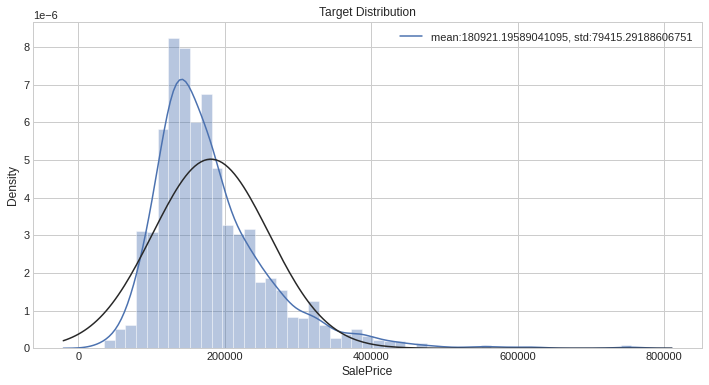

In [ ]:
(mu, sigma) = norm.fit(df[target])
plt.figure(figsize = (12,6))
sns.distplot(df[target], kde=True, hist=True, fit=norm)
plt.title('Target Distribution', fontsize=12)
plt.legend([f"mean:{mu}, std:{sigma}"],loc="best")
plt.show()

In [ ]:
df[target].describe()

# Cleaning Null-Values in Numerical Columns

In [ ]:
df[num_cols].isnull().sum()[df[num_cols].isnull().sum()>0]/df.shape[0]*100

LotFrontage    17.739726
MasVnrArea      0.547945
GarageYrBlt     5.547945
dtype: float64

In [ ]:
# Impute missing Area with 0 and missing Type with "None"
print(df.MasVnrArea.isnull().sum() == df.MasVnrType.isnull().sum())
print(df[(df.MasVnrArea==0) & (df.MasVnrType=="None")].shape[0] == df[(df.MasVnrArea==0) | (df.MasVnrType=="None")].shape[0])

True
False


In [ ]:
df[["MasVnrArea", "MasVnrType"]][(df.MasVnrArea!=0) & (df.MasVnrType=="None") | (df.MasVnrArea==0) & (df.MasVnrType!="None")]

,MasVnrArea,MasVnrType
Id,,
625,288.0,None
689,0.0,BrkFace
774,1.0,None
1231,1.0,None
1242,0.0,Stone
1301,344.0,None
1335,312.0,None


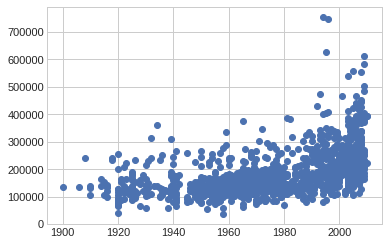

In [ ]:
plt.scatter(df.GarageYrBlt, df[target])

In [ ]:
df[df.GarageYrBlt.isnull()][[col for col in df.columns if "Garage" in col]].sum()

GarageType      0.0
GarageYrBlt     0.0
GarageFinish    0.0
GarageCars      0.0
GarageArea      0.0
GarageQual      0.0
GarageCond      0.0
dtype: float64

Missing Values in GarageYrBlt correlate with no values in the other columns, indicating a lack of any Garage.

For now let's impute the mean for the Pipeline.
Ideally we'd also create a new column keeping track that the Garage is indeed missing - but I don't know how to do this in a pipeline so that's a question for later.

# Custom Feature Union for DateFrameMapper
plus Custom Transformer to add columns



In [6]:
class DFM_FeatureUnion():
  def __init__(self, transformer_list):
    self.transformer_list = transformer_list

  def fit(self, X, y=None):
    for (_, transformer, _) in self.transformer_list:
      transformer.fit(X,y)
    return self

  def transform(self, X):
    trans = []
    for (_, transformer, _) in self.transformer_list:
      trans.append(transformer.transform(X))
    return pd.concat(trans, axis=1)
  
  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X)

class CustomColAdd(BaseEstimator, TransformerMixin):
  def __init__(self, target, categories):
    self.categories = categories
    self.target = target

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    return pd.DataFrame( X[self.categories].sum(axis=1), columns=[self.target])

  def fit_transform(self, X, y=None):
    #placeholder
    self.fit(X, y)
    return self.transform(X)

In [7]:
#df[['TotalBsmtSF', '1stFlrSF', '2ndFlrSF']].sum(axis=0)
# adder = CustomColAdd("area", ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'])
# adder.fit_transform(df).head()

# buildFeaturesPipeline with native DFM

In [ ]:
print(num_cols)

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')


In [43]:
def buildFeaturesPipeline(num_clusters = 4, num_PCAfeatures = 4, num_Poly = 2):
    # sepearte obj_cols according to the fill-value
    fill_none = ['MasVnrType','GarageType', 'GarageQual', 'GarageFinish',
                'GarageCond', 'FireplaceQu', 'BsmtQual','BsmtCond','BsmtExposure',
                'BsmtFinType1', 'BsmtFinType2']

    drop_obj = ["Alley","PoolQC","Fence","MiscFeature"]

    fill_frequent = [col for col in obj_cols if col not in set(fill_none + drop_obj)]


    obj_filler = DataFrameMapper(
        [([col], SimpleImputer(strategy="constant", fill_value="None"))
          for col in fill_none]
          +
        [([col], SimpleImputer(strategy="most_frequent"))
          for col in fill_frequent]
        ,df_out=True
    )


    # Features to encode
    obj_ord = ['GarageQual','GarageCond','FireplaceQu','BsmtQual','BsmtCond',
               "BsmtExposure",
               "GarageFinish",
               'BsmtFinType1', 'BsmtFinType2']

    obj_oh = ["MasVnrType", "GarageType"]

    obj_ord_DFM = DataFrameMapper(
          [
           # Generate a list Comprehension for several encoders
           # DFM suffix/prefix attribut doesn't work
           ([col], OrdinalEncoder(categories=[["Ex", "Gd", "TA", "Fa", "Po", "None"]], dtype=np.int64), {'alias':'ord_'+col})
              for col in ['GarageQual','GarageCond','FireplaceQu','BsmtQual','BsmtCond']
            ]
          +
          [
           (["BsmtExposure"], OrdinalEncoder(categories=[["Gd","Av","Mn","No","None"]], dtype=np.int64), {"alias":"ord_BsmtExposure"} )
           ,
          (["GarageFinish"], OrdinalEncoder(categories=[['Fin', 'RFn', 'Unf', 'None']], dtype=np.int64), {'alias':'ord_GarageFinish'} )
          ]
          ,df_out=True
    )
    
    # use LabelBinarizer as OneHotEncoder seems runs problems within DFM
    # also LB does actually provide meaningful column-names, which the SKlearn OHE does not
    obj_oh_DFM = DataFrameMapper(
        [
         (["MasVnrType"], LabelBinarizer()), # 4 Values
         (["GarageType"], LabelBinarizer())  # 6 Values
        ]
        ,df_out=True
    )

    obj_encode_union = DFM_FeatureUnion(
        transformer_list=[
         ("ord", obj_ord_DFM, obj_ord),                 
         ("OH", obj_oh_DFM, obj_oh)
        ]
    )

    categorical_starter = Pipeline(
        [
         ("fill", obj_filler),
         ("encode", obj_encode_union)
        ]
    )

    # add categorical features (not implemented)
    categorical_features = DFM_FeatureUnion(
        transformer_list = [
                            ('original_features',categorical_starter)
                            ])

    #--------------------------------------- starting point for numerics workflow -------------------------------------------------------#
    num_cols = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold']

    # Columns to drop because of low info
    num_drop = ["MoSold", "YrSold", "PoolArea", "EnclosedPorch", "3SnPorch"] #

    # Creating a dict of new features as tuples with new header - Adding columns
    num_new_dict = {
        "TotalSF": ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'],
        "TotalBaths": ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath']
    }
    num_new_cols = list(num_new_dict.keys())
    num_new_cols_drop = list(set(col for key, value in num_new_dict.items() for col in value))

    #select the columns and apply filler + scaler
    fill_0 = ["MasVnrArea"]
    
    fill_mean = [col for col in num_cols if col not in set(fill_0 + num_drop)]

    num_cols_fill = fill_0+fill_mean

    num_cols_drop = set(num_new_cols_drop + num_drop)
    # print(num_cols_drop)
    num_cols_nondrop = [col for col in num_cols if col not in num_cols_drop]
    num_cols_final = num_cols_nondrop + num_new_cols
    #print(num_cols_final)

    numeric_impute_DFM = DataFrameMapper(
      [(fill_0, SimpleImputer(strategy="constant", fill_value=0))]
      +
      [([col], SimpleImputer(strategy="mean")) for col in fill_mean]
      ,df_out=True
    )

    numeric_norm_DFM = DataFrameMapper(
        [([col], StandardScaler(), {"alias":"norm_"+col})
        for col in num_cols_final
        ],
        df_out=True)
    
    # add numerical features (not implemented)
    numeric_new_features = DFM_FeatureUnion(
        [
         (key, CustomColAdd(key, value), value)
         for key, value in num_new_dict.items()
        ]
    )

    numeric_features = DFM_FeatureUnion(
        transformer_list = [
                            ('original_features', numeric_impute_DFM, num_cols_nondrop),
                            ('feature_engeneer', numeric_new_features, num_new_cols)
                            ])

    numeric_prep_DFM = Pipeline(
        [
         #("all_features", numeric_impute_DFM),
         ("all_features", numeric_features),
         ("scale", numeric_norm_DFM)
        ]
    )
   
    
    # union the categorical and numerical pipelines
    features_merged = DFM_FeatureUnion(
        transformer_list = [
                            ('categorical_pipeline', categorical_starter, obj_cols),
                            #('categorical_pipeline', categorical_features, obj_cols),
                            #('numerical_pipeline', numeric_prep_DFM, num_cols+["TotalSF"])
                            ('numerical_pipeline', numeric_prep_DFM, num_cols_final)
                            ])
    
    # Final Pipeline to return
    features_pipeline = Pipeline(
        steps=[
               ('features', features_merged)
               ])
    
    return features_pipeline

feature_pipeline = buildFeaturesPipeline()
columns = feature_pipeline.fit_transform(df.iloc[:50,:]).columns
print(len(columns))
columns

42


Index(['ord_GarageQual', 'ord_GarageCond', 'ord_FireplaceQu', 'ord_BsmtQual',
       'ord_BsmtCond', 'ord_BsmtExposure', 'ord_GarageFinish',
       'MasVnrType_BrkFace', 'MasVnrType_None', 'MasVnrType_Stone',
       'GarageType_Attchd', 'GarageType_BuiltIn', 'GarageType_CarPort',
       'GarageType_Detchd', 'GarageType_None', 'norm_MSSubClass',
       'norm_LotFrontage', 'norm_LotArea', 'norm_OverallQual',
       'norm_OverallCond', 'norm_YearBuilt', 'norm_YearRemodAdd',
       'norm_MasVnrArea', 'norm_BsmtFinSF1', 'norm_BsmtFinSF2',
       'norm_BsmtUnfSF', 'norm_LowQualFinSF', 'norm_GrLivArea',
       'norm_BedroomAbvGr', 'norm_KitchenAbvGr', 'norm_TotRmsAbvGrd',
       'norm_Fireplaces', 'norm_GarageYrBlt', 'norm_GarageCars',
       'norm_GarageArea', 'norm_WoodDeckSF', 'norm_OpenPorchSF',
       'norm_3SsnPorch', 'norm_ScreenPorch', 'norm_MiscVal', 'norm_TotalSF',
       'norm_TotalBaths'],
      dtype='object')

# Mutual Information

In [ ]:
feature_pipeline = buildFeaturesPipeline()
X = feature_pipeline.fit_transform(df)
y = df.SalePrice.copy()

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show a few features with their MI scores

norm_OverallQual      0.568143
norm_YearBuilt        0.366940
ord_BsmtQual          0.334299
norm_MSSubClass       0.275406
norm_YearRemodAdd     0.247841
norm_2ndFlrSF         0.201925
norm_LotArea          0.157982
GarageType_Attchd     0.119541
norm_WoodDeckSF       0.108391
norm_HalfBath         0.083580
ord_GarageCond        0.077127
GarageType_None       0.054483
MasVnrType_BrkFace    0.030308
norm_KitchenAbvGr     0.017839
norm_BsmtFullBath     0.015506
norm_LowQualFinSF     0.010554
norm_YrSold           0.002004
norm_PoolArea         0.000000
Name: MI Scores, dtype: float64

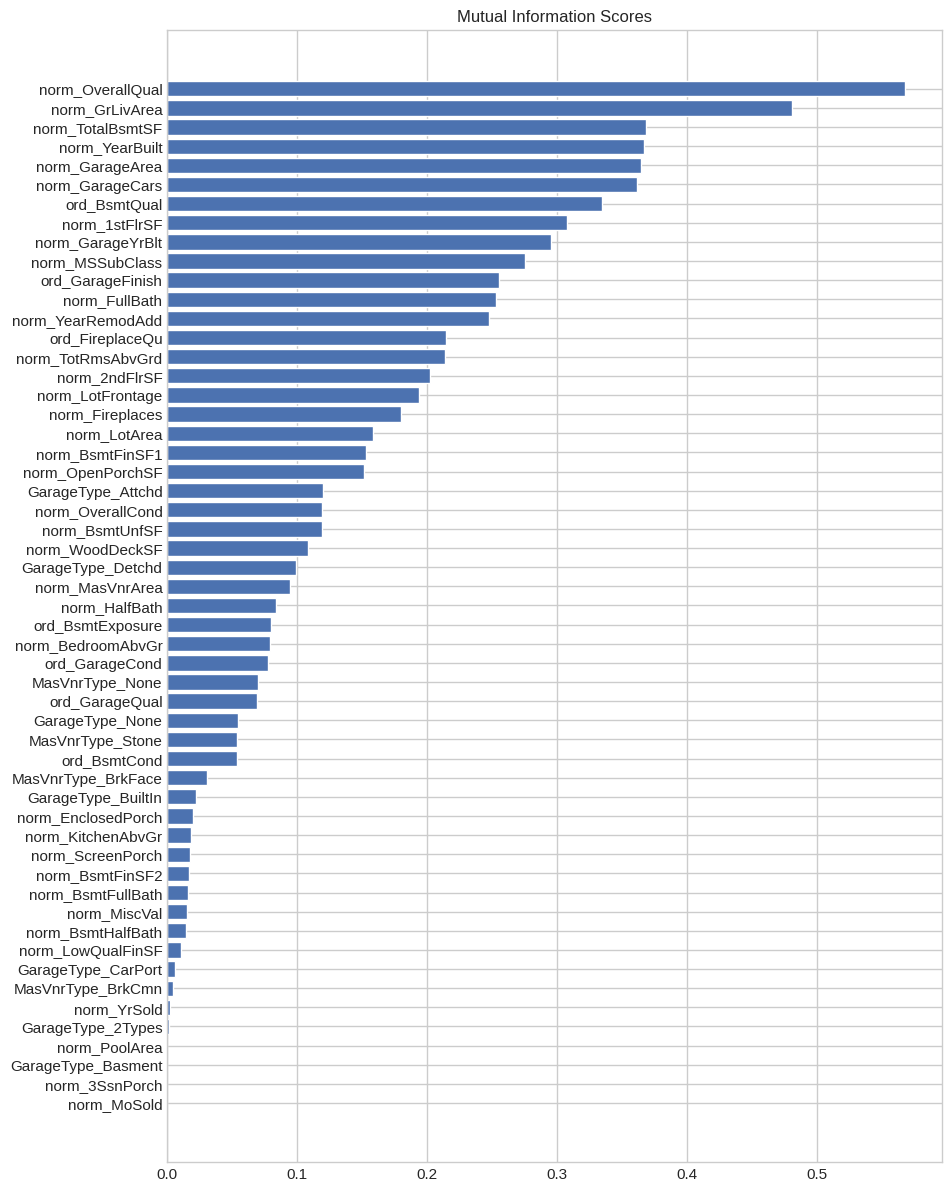

In [ ]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(10, 15))
plot_mi_scores(mi_scores)

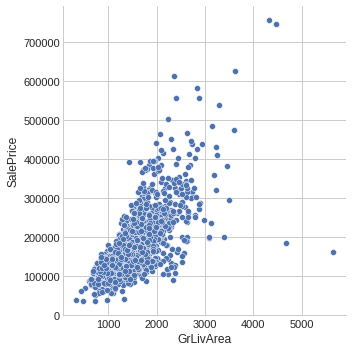

In [ ]:
sns.relplot(x="GrLivArea", y="SalePrice", data=df);

# PCA

In [ ]:
pca = PCA()
X_pca = pca.fit_transform(X)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54
0,0.598091,-0.657415,-2.997089,0.204604,2.066988,-0.601840,0.337937,-1.450821,0.332922,-0.888963,-0.318131,0.114028,-0.583185,0.221767,-0.041436,0.240364,-0.116153,-0.075696,-0.832947,-0.431389,-0.914030,0.188742,0.401716,0.491378,0.070705,-0.072882,-0.181377,-0.106229,0.222392,0.394279,-0.044469,-0.625127,0.102310,-0.017310,0.634558,-0.081439,-0.453857,-0.143395,0.122106,0.246149,-0.011344,-0.095648,0.172616,-0.054412,-0.000656,0.035097,-0.011267,-0.003608,-0.006092,0.015851,-2.353196e-15,1.292988e-14,4.315467e-15,-2.989094e-15
1,1.069087,-1.091076,2.143981,-0.086805,0.210568,-0.649437,-1.858122,2.525091,-2.885974,0.364450,-0.405451,-0.382177,-1.026078,0.962388,-0.574484,-1.197078,0.531889,0.744468,-1.369602,0.415921,-0.820430,-1.028774,-0.245883,-1.021093,-0.757784,0.198153,0.314423,0.324247,0.922920,-1.029140,-0.243521,-0.356263,0.358842,0.183850,-0.503072,-0.266893,0.082519,0.315347,-0.171097,0.032181,0.422732,-0.007358,0.351415,0.079492,0.004835,0.010804,0.016768,-0.005296,-0.012818,0.015258,4.147389e-14,-1.951419e-15,-3.264341e-16,-1.915014e-15
2,2.225052,-0.000313,-0.877655,-1.462145,1.095633,0.184197,0.308112,-0.062424,0.520518,-0.551318,-0.204634,-0.496201,0.467449,-0.380570,0.241874,0.268590,-0.145181,-0.255939,-0.214784,0.962929,-0.154600,0.605331,-0.367253,0.612996,0.016648,-0.366395,-0.493891,-0.328507,0.204014,0.086840,0.163748,-0.704259,0.735152,0.112527,0.223455,0.124422,0.141514,-0.763799,0.137479,-0.134131,-0.185184,0.150927,0.252707,-0.214491,-0.019499,0.002196,0.001128,-0.003339,-0.015294,0.014902,3.388755e-15,8.079010e-15,2.149455e-15,2.676374e-16
3,0.258121,1.945273,1.596807,-0.896290,-0.091309,-0.516842,1.038900,-0.574375,1.813201,2.975903,-2.026430,-0.024994,-1.103792,0.003117,0.192688,1.639762,-0.664637,0.125741,-1.381478,-0.151954,-0.821328,-0.266114,1.169607,-1.064725,0.547272,-1.564854,0.162634,-1.709682,-0.239434,0.276500,-0.756700,-0.153174,-0.604525,0.549827,0.633313,0.265043,0.035106,-0.371118,0.862305,-0.139320,0.638170,-0.069210,-1.180524,-0.098830,-0.094200,-0.001793,-0.016758,0.025326,-0.019686,-0.006231,2.477272e-15,6.717956e-15,-1.504691e-15,3.795743e-15
4,4.610783,0.721530,-1.251792,0.244110,1.612795,-0.318848,0.184196,0.919717,0.252666,-0.472698,-0.352673,-0.792042,0.329168,-1.136798,0.775775,-0.182648,-0.458345,-0.669922,0.533425,1.082567,0.503077,0.468120,-0.578132,-0.316053,-0.525839,-0.940433,-0.471219,-0.470178,-0.236539,0.109097,-0.179400,-0.523741,0.123538,-0.349162,0.324246,0.011036,0.128187,-0.181720,0.023676,0.234033,0.071924,-0.308805,0.158610,-0.131648,-0.022967,0.029455,0.006699,0.011409,-0.004998,-0.018903,-2.356002e-15,4.949228e-18,1.022054e-15,1.597004e-15


In [ ]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54
ord_GarageQual,-0.092775,0.057502,0.000141,0.068389,0.009979,0.395378,-0.155175,-0.062671,-0.035809,-0.142574,-0.011969,-0.035897,-0.012049,-0.008243,0.054342,0.045059,0.013640,-0.021047,-0.043470,0.034601,-0.023797,0.103932,0.030229,-0.137321,0.106132,-0.162607,0.093120,0.003726,0.014486,-0.010996,-0.275567,0.047562,0.088120,-0.239730,-0.079526,0.054407,-0.007568,0.025436,-0.096550,0.009378,-0.036845,-0.048566,-0.012154,-0.072436,-0.663497,-0.235652,0.026464,-0.061745,-0.073872,0.107194,-2.867194e-15,-0.000000e+00,0.000000e+00,0.000000e+00
ord_GarageCond,-0.090561,0.061695,-0.000236,0.068403,0.011672,0.397543,-0.148308,-0.060218,-0.036014,-0.133646,-0.012543,-0.030922,-0.002538,-0.010316,0.037739,0.048878,0.009991,-0.016101,-0.055349,0.033987,-0.019480,0.123142,0.022273,-0.142104,0.101005,-0.171456,0.093963,0.006875,0.011474,-0.026143,-0.279079,0.065503,0.071190,-0.205347,-0.068537,0.066078,0.004448,0.001366,-0.069927,0.017034,-0.009979,-0.054789,-0.005913,-0.105788,0.693856,0.147919,-0.015805,-0.031653,-0.100486,0.112011,2.185013e-15,2.899157e-16,-1.522220e-16,-4.350903e-16
ord_FireplaceQu,-0.414539,-0.259767,-0.493093,0.457098,0.129877,-0.184786,-0.100413,0.037983,0.037733,-0.044202,0.004194,0.059454,-0.057114,-0.023758,0.046282,0.034920,-0.028253,0.008801,0.069430,0.006607,0.038413,-0.024551,0.083586,0.041226,0.020601,0.076283,0.002665,0.126648,-0.030763,-0.025687,0.006881,-0.045043,0.066920,-0.004192,0.088173,0.367600,0.021327,0.199923,0.002876,0.005484,-0.015819,0.003447,0.029041,0.018235,0.008239,-0.008991,-0.001810,-0.002070,-0.000110,-0.002780,1.339258e-16,2.104362e-16,1.518948e-16,1.058428e-16
ord_BsmtQual,-0.182599,0.141846,0.103397,0.066520,-0.017579,-0.095784,0.223364,0.021022,-0.058612,-0.034123,0.028459,-0.056424,0.092207,0.019232,-0.060638,-0.104684,0.052632,-0.016497,-0.051852,-0.086303,0.041542,0.217830,0.075763,-0.164956,-0.056763,-0.054041,-0.247061,0.256867,-0.270851,-0.013494,-0.078087,-0.120405,0.093884,0.138781,-0.106700,0.055638,0.151942,-0.178789,0.032540,0.435451,-0.080512,-0.131508,-0.451729,-0.014017,-0.016388,0.011404,-0.011002,0.006145,-0.004888,-0.001447,1.398508e-16,-2.436935e-17,-4.672585e-17,-4.969697e-16
ord_BsmtCond,-0.047486,0.055127,0.001749,0.024295,-0.015692,0.015258,0.192440,-0.025393,-0.025068,-0.037954,0.024297,-0.058990,0.081051,0.044763,-0.066408,-0.078915,0.035936,0.004506,-0.076143,-0.014633,0.067191,0.189193,0.115798,-0.162356,-0.050805,-0.047227,-0.141858,0.282565,-0.217649,0.087842,-0.015459,-0.098038,-0.051976,0.037574,-0.134482,-0.040092,0.078171,0.008671,-0.198613,-0.036899,0.304370,0.189910,0.679029,0.108419,-0.011250,0.020164,0.016092,-0.018152,0.004879,0.001161,-1.765617e-16,-1.572966e-17,3.104606e-17,-3.206074e-17


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5500a29550>,
      dtype=object)

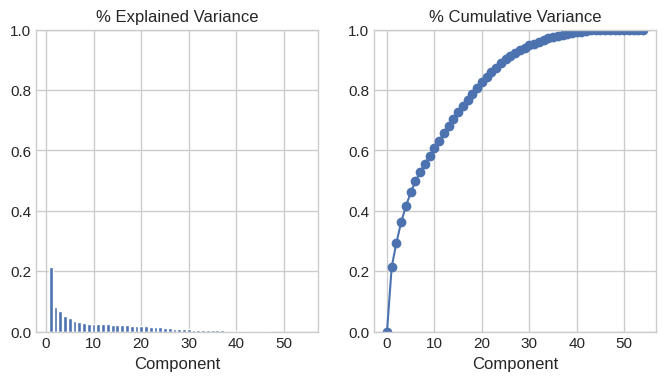

In [ ]:
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

plot_variance(pca)

In [ ]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X_pca, y, discrete_features=False)
mi_scores

PC1     1.020432
PC42    0.124612
PC3     0.115736
PC6     0.108788
PC50    0.107579
PC49    0.097193
PC4     0.073001
PC5     0.068646
PC2     0.057770
PC11    0.054640
PC31    0.054276
PC43    0.049315
PC10    0.048984
PC26    0.048060
PC7     0.043438
PC48    0.043331
PC19    0.041642
PC15    0.041233
PC33    0.039759
PC25    0.038726
PC39    0.037889
PC36    0.037310
PC16    0.037088
PC45    0.036411
PC23    0.035567
PC47    0.035313
PC13    0.035068
PC34    0.035043
PC29    0.035031
PC52    0.034532
PC21    0.030819
PC12    0.029799
PC44    0.028943
PC24    0.028712
PC46    0.028005
PC41    0.027889
PC18    0.024470
PC27    0.022591
PC40    0.022493
PC30    0.020990
PC35    0.018977
PC32    0.017831
PC14    0.015657
PC38    0.013889
PC22    0.006713
PC8     0.006559
PC28    0.003227
PC53    0.000241
PC17    0.000000
PC20    0.000000
PC9     0.000000
PC37    0.000000
PC51    0.000000
PC54    0.000000
Name: MI Scores, dtype: float64

# Create the Model (without CV-optimizer)

RMSE= 19678.246


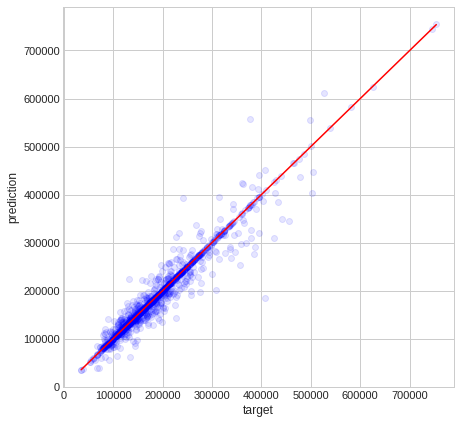

In [50]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df["SalePrice"], test_size = 0.4)
feature_pipeline = buildFeaturesPipeline()
# feature_pipeline.fit_transform(df)

params = {'num_leaves': 50, 
          'n_estimators': 1600, 
          'min_data': 50, 
          'max_depth': 5, 
          'learning_rate': 0.3, 
          'lambda_l2': 9, 
          'lambda_l1': 5}
model_lgb = LGBMRegressor(**params)

my_pipeline = Pipeline(
    steps=[
           ("preprocessing", feature_pipeline),
           ("model", model_lgb)
    ]
)

my_pipeline.fit(X_train, y_train)
prediction = my_pipeline.predict(df.iloc[:,:-1])
pred_chart(df.iloc[:,-1], prediction)

In [ ]:
predict_test = my_pipeline.predict(df_test)
submission = pd.DataFrame({"SalePrice":predict_test}, index=df_test.index)
submission.head()

,SalePrice
Id,
1461,133576.951267
1462,151417.312765
1463,171901.000194
1464,186464.335316
1465,185056.822555


In [ ]:
#submission.to_csv("Submission_lgb_2021-08-31.csv")

# Using Randomized CV

In [14]:
from sklearn.model_selection import RandomizedSearchCV

In [15]:
# prepper = buildFeaturesPipeline()
# X_train, X_val, y_train, y_val = train_test_split(df.iloc[:,:-1], df["SalePrice"], test_size = 0.4)

In [44]:
param_grid =  {
          'learning_rate': [0.1, 0.3, 0.5, 1],
          'num_leaves': np.arange(5, 51, 5),
          'min_data': np.arange(50,651,50),
          'max_depth': np.arange(5, 31, 5),
          "n_estimators": np.arange(100,5001,100),
          "lambda_l1" : np.arange(0,10,1),
          "lambda_l2" : np.arange(0,10,1)
          }

# params={
#     "sub_feature" : 0.1,
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': 'rmse',
#     'num_leaves': 15,
#     'n_estimators': 5000,
#     'min_data': 450,
#     'max_depth': 10,
#     'learning_rate': 0.1,
#     'lambda_l2': 4,
#     'lambda_l1': 2
# }

model_lgb = LGBMRegressor(**param_grid)

randomized_search = RandomizedSearchCV(param_distributions = param_grid,
                                      estimator=model_lgb,
                                      scoring="neg_mean_squared_error",
                                      n_iter=50,
                                      cv=5,
                                      verbose=1,
                                      random_state=7
                                      )

pipe = Pipeline(steps=[
                       ("preprocessor", prepper),
                       ("model", randomized_search)
])

pipe.fit(df.iloc[:,:-1], df["SalePrice"])

Fitting 5 folds for each of 50 candidates, totalling 250 fits


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('features',
                                  <__main__.DFM_FeatureUnion object at 0x7f1cd722f550>)])),
                ('model',
                 RandomizedSearchCV(cv=5,
                                    estimator=LGBMRegressor(lambda_l1=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                                            lambda_l2=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                                            learning_rate=[0.1,
                                                                           0.3,
                                                                           0.5,
                                                                           1],
                                                            max_depth=array([ 5, 10, 15, 20, 25, 30]),
                                                            min_data=array([ 50, 100, 150, 200, 250,...
                 

In [45]:
print(randomized_search.best_params_)
print(np.sqrt(np.abs(randomized_search.best_score_)))
print(randomized_search.best_estimator_)

{'num_leaves': 50, 'n_estimators': 1600, 'min_data': 50, 'max_depth': 5, 'learning_rate': 0.3, 'lambda_l2': 9, 'lambda_l1': 5}
31337.631477296512
LGBMRegressor(lambda_l1=5, lambda_l2=9, learning_rate=0.3, max_depth=5,
              min_data=50, n_estimators=1600, num_leaves=50)


Prediction chart seems to give a RMSE of 323 with these params
{'num_leaves': 50, 'n_estimators': 1600, 'min_data': 50, 'max_depth': 5, 'learning_rate': 0.3, 'lambda_l2': 9, 'lambda_l1': 5}

Though CV itself gives: 31255.70180156976
Also using them on a model directly (before CV part) gives 19678

RMSE= 323.584


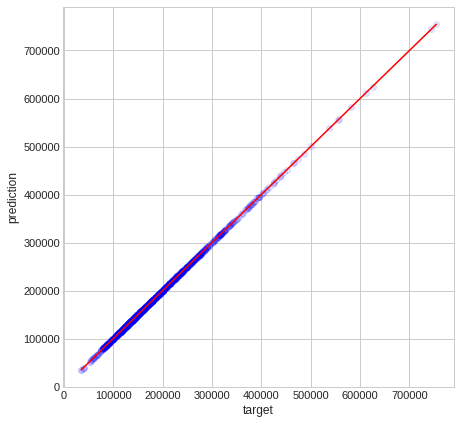

In [51]:
prediction = pipe.predict(df.iloc[:,:-1])
pred_chart(df.iloc[:,-1], prediction)

# pred_chart(pipe.predict(df.iloc[:,:-1]), df["SalePrice"])

In [48]:
predict_test = pipe.predict(df_test)
submission = pd.DataFrame({"SalePrice":predict_test}, index=df_test.index)
submission.head()

,SalePrice
Id,
1461,129321.311918
1462,161367.657161
1463,186574.536259
1464,195196.870882
1465,188077.222141


In [49]:
# note: appearently the result is pretty bad compared to previous submissions
submission.to_csv("lgbm_cv_22-07-11.csv")